# Control with Approximation

## Episodic Sarsa with Function Approximation

### State-values to action-values

- State-values

$$
v_\pi(s) \approx \hat{v}(s,\mathbf{w}) \doteq \mathbf{w}^T\mathbf{x}(s)
$$

- Action-values

$$
q_\pi(s,a) \approx \hat{q}(s,a,\mathbf{w}) \doteq \mathbf{w}^T\mathbf{x}(s,a)
$$



## Example: Episodic Sarsa in Mountain Car



In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d.axes3d import Axes3D
from math import floor

#######################################################################
# Following are some utilities for tile coding from Rich.
# To make each file self-contained, I copied them from
# http://incompleteideas.net/tiles/tiles3.py-remove
# with some naming convention changes
#
# Tile coding starts
class IHT:
    "Structure to handle collisions"
    def __init__(self, size_val):
        self.size = size_val
        self.overfull_count = 0
        self.dictionary = {}

    def count(self):
        return len(self.dictionary)

    def full(self):
        return len(self.dictionary) >= self.size

    def get_index(self, obj, read_only=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif read_only:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfull_count == 0: print('IHT full, starting to allow collisions')
            self.overfull_count += 1
            return hash(obj) % self.size
        else:
            d[obj] = count
            return count

def hash_coords(coordinates, m, read_only=False):
    if isinstance(m, IHT): return m.get_index(tuple(coordinates), read_only)
    if isinstance(m, int): return hash(tuple(coordinates)) % m
    if m is None: return coordinates

def tiles(iht_or_size, num_tilings, floats, ints=None, read_only=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    if ints is None:
        ints = []
    qfloats = [floor(f * num_tilings) for f in floats]
    tiles = []
    for tiling in range(num_tilings):
        tilingX2 = tiling * 2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // num_tilings)
            b += tilingX2
        coords.extend(ints)
        tiles.append(hash_coords(coords, iht_or_size, read_only))
    return tiles
# Tile coding ends
#######################################################################

# all possible actions
ACTION_REVERSE = -1
ACTION_ZERO = 0
ACTION_FORWARD = 1
# order is important
ACTIONS = [ACTION_REVERSE, ACTION_ZERO, ACTION_FORWARD]

# bound for position and velocity
POSITION_MIN = -1.2
POSITION_MAX = 0.5
VELOCITY_MIN = -0.07
VELOCITY_MAX = 0.07

# use optimistic initial value, so it's ok to set epsilon to 0
EPSILON = 0

# take an @action at @position and @velocity
# @return: new position, new velocity, reward (always -1)
def step(position, velocity, action):
    new_velocity = velocity + 0.001 * action - 0.0025 * np.cos(3 * position)
    new_velocity = min(max(VELOCITY_MIN, new_velocity), VELOCITY_MAX)
    new_position = position + new_velocity
    new_position = min(max(POSITION_MIN, new_position), POSITION_MAX)
    reward = -1.0
    if new_position == POSITION_MIN:
        new_velocity = 0.0
    return new_position, new_velocity, reward

# wrapper class for state action value function
class ValueFunction:
    # In this example I use the tiling software instead of implementing standard tiling by myself
    # One important thing is that tiling is only a map from (state, action) to a series of indices
    # It doesn't matter whether the indices have meaning, only if this map satisfy some property
    # View the following webpage for more information
    # http://incompleteideas.net/sutton/tiles/tiles3.html
    # @max_size: the maximum # of indices
    def __init__(self, step_size, num_of_tilings=8, max_size=2048):
        self.max_size = max_size
        self.num_of_tilings = num_of_tilings

        # divide step size equally to each tiling
        self.step_size = step_size / num_of_tilings

        self.hash_table = IHT(max_size)

        # weight for each tile
        self.weights = np.zeros(max_size)

        # position and velocity needs scaling to satisfy the tile software
        self.position_scale = self.num_of_tilings / (POSITION_MAX - POSITION_MIN)
        self.velocity_scale = self.num_of_tilings / (VELOCITY_MAX - VELOCITY_MIN)

    # get indices of active tiles for given state and action
    def get_active_tiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        active_tiles = tiles(self.hash_table, self.num_of_tilings,
                            [self.position_scale * position, self.velocity_scale * velocity],
                            [action])
        return active_tiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_MAX:
            return 0.0
        active_tiles = self.get_active_tiles(position, velocity, action)
        return np.sum(self.weights[active_tiles])

    # learn with given state, action and target
    def learn(self, position, velocity, action, target):
        active_tiles = self.get_active_tiles(position, velocity, action)
        estimation = np.sum(self.weights[active_tiles])
        delta = self.step_size * (target - estimation)
        for active_tile in active_tiles:
            self.weights[active_tile] += delta

    # get # of steps to reach the goal under current state value function
    def cost_to_go(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

# get action at @position and @velocity based on epsilon greedy policy and @valueFunction
def get_action(position, velocity, value_function):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    values = []
    for action in ACTIONS:
        values.append(value_function.value(position, velocity, action))
    return np.random.choice([action_ for action_, value_ in enumerate(values) if value_ == np.max(values)]) - 1

# semi-gradient n-step Sarsa
# @valueFunction: state value function to learn
# @n: # of steps
def semi_gradient_n_step_sarsa(value_function, n=1):
    # start at a random position around the bottom of the valley
    current_position = np.random.uniform(-0.6, -0.4)
    # initial velocity is 0
    current_velocity = 0.0
    # get initial action
    current_action = get_action(current_position, current_velocity, value_function)

    # track previous position, velocity, action and reward
    positions = [current_position]
    velocities = [current_velocity]
    actions = [current_action]
    rewards = [0.0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # take current action and go to the new state
            new_postion, new_velocity, reward = step(current_position, current_velocity, current_action)
            # choose new action
            new_action = get_action(new_postion, new_velocity, value_function)

            # track new state and action
            positions.append(new_postion)
            velocities.append(new_velocity)
            actions.append(new_action)
            rewards.append(reward)

            if new_postion == POSITION_MAX:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += rewards[t]
            # add estimated state action value to the return
            if update_time + n <= T:
                returns += value_function.value(positions[update_time + n],
                                                velocities[update_time + n],
                                                actions[update_time + n])
            # update the state value function
            if positions[update_time] != POSITION_MAX:
                value_function.learn(positions[update_time], velocities[update_time], actions[update_time], returns)
        if update_time == T - 1:
            break
        current_position = new_postion
        current_velocity = new_velocity
        current_action = new_action

    return time

# print learned cost to go
def print_cost(value_function, episode, ax):
    grid_size = 40
    positions = np.linspace(POSITION_MIN, POSITION_MAX, grid_size)
    # positionStep = (POSITION_MAX - POSITION_MIN) / grid_size
    # positions = np.arange(POSITION_MIN, POSITION_MAX + positionStep, positionStep)
    # velocityStep = (VELOCITY_MAX - VELOCITY_MIN) / grid_size
    # velocities = np.arange(VELOCITY_MIN, VELOCITY_MAX + velocityStep, velocityStep)
    velocities = np.linspace(VELOCITY_MIN, VELOCITY_MAX, grid_size)
    axis_x = []
    axis_y = []
    axis_z = []
    for position in positions:
        for velocity in velocities:
            axis_x.append(position)
            axis_y.append(velocity)
            axis_z.append(value_function.cost_to_go(position, velocity))

    ax.scatter(axis_x, axis_y, axis_z)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Cost to go')
    ax.set_title('Episode %d' % (episode + 1))


100%|██████████| 9000/9000 [02:30<00:00, 59.84it/s]


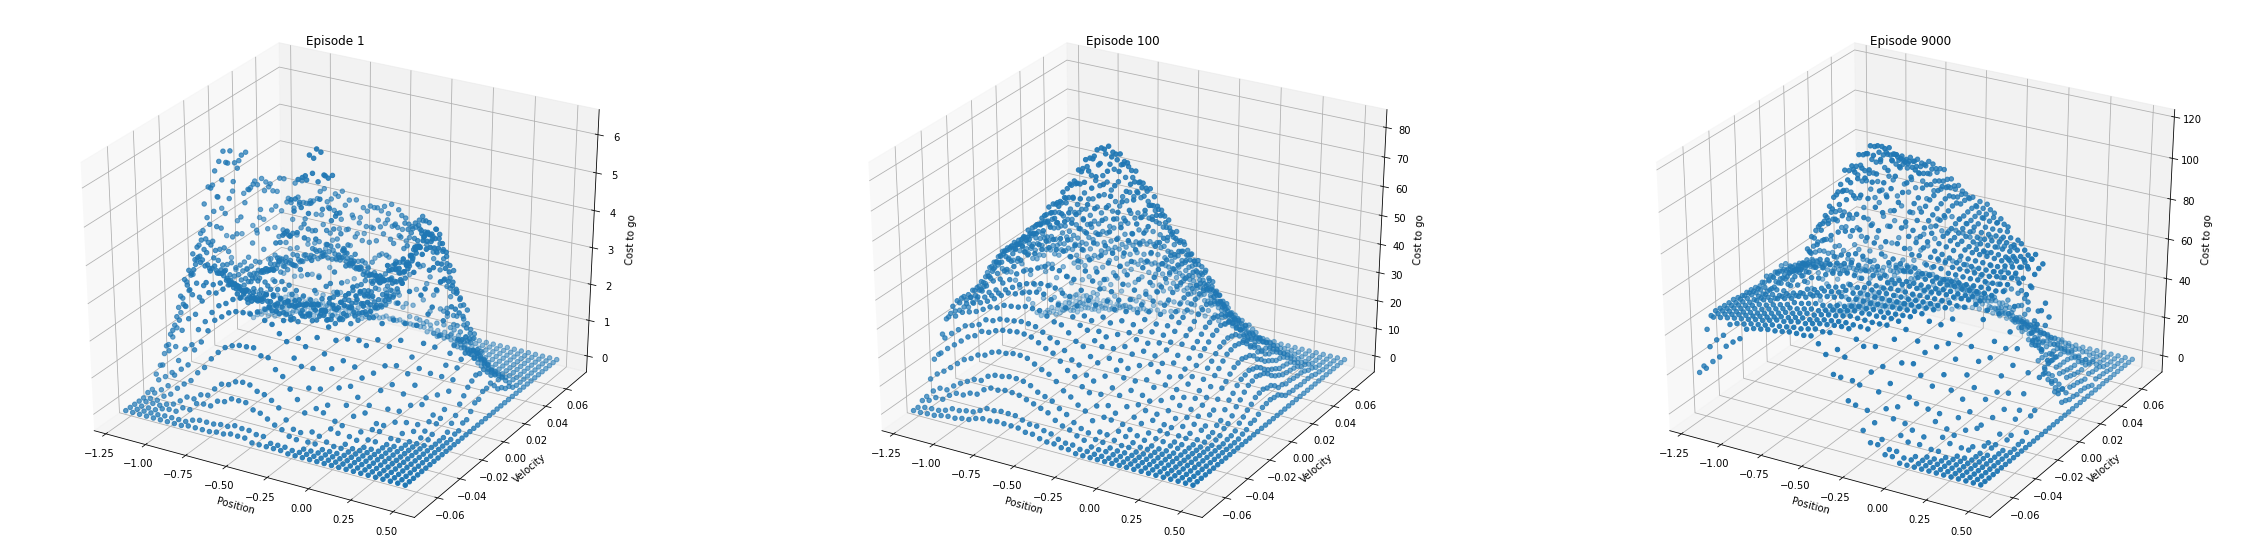

In [2]:
# Figure 10.1, cost to go in a single run
episodes = 9000
plot_episodes = [0, 99, episodes - 1]
fig = plt.figure(figsize=(40, 10))
axes = [fig.add_subplot(1, len(plot_episodes), i+1, projection='3d') for i in range(len(plot_episodes))]
num_of_tilings = 8
alpha = 0.3
value_function = ValueFunction(alpha, num_of_tilings)
for ep in tqdm(range(episodes)):
    semi_gradient_n_step_sarsa(value_function)
    if ep in plot_episodes:
        print_cost(value_function, ep, axes[plot_episodes.index(ep)])

## Expected Sarsa with Function Approximation

### From Sarsa to Expected Sarsa

- Sarsa:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha (R_{t+1}+\gamma Q(S_{t+1},A_{t+1})-Q(S_t,A_t))
$$

- Expected Sarsa:

$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha (R_{t+1}+\gamma \sum_{a'}\pi(a'|S_{t+1})Q(S_{t+1},a')-Q(S_t,A_t))
$$

### Expected Sarsa with Function Approximation

- Sarsa:

$$
\mathbf{w} \leftarrow \mathbf{w} + \alpha (R_{t+1}+\gamma \hat{q}(S_{t+1},A_{t+1},\mathbf{w})-\hat{q}(S_t,A_t,\mathbf{w}))\nabla \hat{q}(S_t,A_t,\mathbf{w})
$$

- Expected Sarsa:

$$
\begin{gather*}
\mathbf{w} \leftarrow \mathbf{w} + \alpha (R_{t+1}+\gamma \sum_{a'}\pi(a'|S_{t+1})\hat{q}(S_{t+1},a',\mathbf{w})-\hat{q}(S_t,A_t,\mathbf{w}))\nabla \hat{q}(S_t,A_t,\mathbf{w})\\
q_\pi(s,a) \approx \hat{q}(s,a,\mathbf{w})
\end{gather*}
$$

### Expected Sarsa to Q-learning

- Expected Sarsa:

$$
\mathbf{w} \leftarrow \mathbf{w} + \alpha (R_{t+1}+\gamma \sum_{a'}\pi(a'|S_{t+1})\hat{q}(S_{t+1},a',\mathbf{w})-\hat{q}(S_t,A_t,\mathbf{w}))\nabla \hat{q}(S_t,A_t,\mathbf{w})
$$

- Q-learning:

$$
\begin{gather*}
\mathbf{w} \leftarrow \mathbf{w} + \alpha (R_{t+1}+\gamma \max_{a'}\hat{q}(S_{t+1},a',\mathbf{w})-\hat{q}(S_t,A_t,\mathbf{w}))\nabla \hat{q}(S_t,A_t,\mathbf{w})\\
q_\pi(s,a) \approx \hat{q}(s,a,\mathbf{w}) = \mathbf{w}^T\mathbf{x}(s,a)
\end{gather*}
$$



## Exploration under Function Approximation

- *$\epsilon$-greedy* can be combined with *any function approximation*

## Averate Reward: A New Way of Formulating Control Problems

### The Average Reward objective

$$
\begin{align*}
r(\pi) &\doteq \lim_{h \to \infty}\frac{1}{h}\sum_{t=1}^h\mathbb{E}[R_t|S_0,A_{0:t-1}\sim \pi]\\
       &=\sum_{s}\mu_\pi(s)\sum_{a}\pi(a|s)\sum_{s',r}p(s',r|s,a)r
\end{align*}
$$

### Value Functions for Average Reward

$$
\begin{gather*}
G_t=R_{t+1}-r(\pi)+R_{t+2}-r(\pi)+R_{t+3}-r(\pi)+\ldots\\
q_\pi(s,a)=\mathbb{E}_\pi[G_t|S_t=s,A_t=a]\\
q_\pi(s,a)=\sum_{s',r}p(s',r|s,a)(r-r(\pi) + \sum_{a'}\pi(a'|s')q_\pi(s',a'))
\end{gather*}
$$